In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

# ------------------------
# Settings
# ------------------------
d = 50                # base number of features (large for Gaussian approx)
sigma2 = 1.0
theta_s = 1.5         # effect size under H1
c_by_r = 0.15
# simulation sizes
n_calib = 2000        # sims to calibrate null per n (must be reasonably large)
n_eval = 1000         # sims to estimate type-I / power per n
alpha_values = np.array([0.00, 0.01, 0.02, 0.05, 0.10, 0.15, 0.2, 0.5, 1.0])
n=51

# helper: log pdf under Gaussian approx for Q = RSS/n
def log_gaussian_pdf(x, mu, var):
    return -0.5 * np.log(2 * np.pi * var) - (x - mu)**2 / (2 * var)

def compute_logLR_for_one(n, use_sensitive):
    """Simulate one dataset and return logL_d - logL_d1 (logLR)."""
    X_d = np.random.randn(n, d)
    sensitive = np.random.randn(n, 1)
    X_d1 = np.hstack([X_d, sensitive])

    theta_d = np.random.randn(d)
    theta_d1 = np.hstack([theta_d, theta_s])

    eps = np.random.randn(n) * np.sqrt(sigma2)
    if use_sensitive:
        y = X_d1 @ theta_d1 + eps
    else:
        y = X_d @ theta_d + eps

    # Fit OLS without sensitive attribute
    theta_hat_d = np.linalg.lstsq(X_d, y, rcond=None)[0]
    residuals_d = y - X_d @ theta_hat_d
    Q_obs = (residuals_d.T @ residuals_d) / n

    # Gaussian approx params
    mu_d = sigma2 * d / n
    var_d = 2 * sigma2**2 * d / n**2
    mu_d1 = sigma2 * (d + 1) / n
    var_d1 = 2 * sigma2**2 * (d + 1) / n**2

    logL_d = log_gaussian_pdf(Q_obs, mu_d, var_d)
    logL_d1 = log_gaussian_pdf(Q_obs, mu_d1, var_d1)
    logLR = logL_d - logL_d1
    return float(logLR)

# ------------------------
# Calibration + evaluation
# ------------------------
type1_list = []
power_list = []

for alpha in alpha_values:
    # --- calibrate null distribution of logLR ---
    null_logLRs = np.empty(n_calib)
    for i in range(n_calib):
        null_logLRs[i] = compute_logLR_for_one(n, use_sensitive=False)
    crit = np.quantile(null_logLRs, alpha)   # reject H0 when logLR <= crit

    # sanity: estimate empirical type-I with fresh sims
    null_test_logLRs = np.empty(n_eval)
    for i in range(n_eval):
        null_test_logLRs[i] = compute_logLR_for_one(n, use_sensitive=False)
    type1_emp = np.mean(null_test_logLRs <= crit)

    # estimate power with fresh sims under H1
    alt_logLRs = np.empty(n_eval)
    for i in range(n_eval):
        alt_logLRs[i] = compute_logLR_for_one(n, use_sensitive=True)
    power_emp = np.mean(alt_logLRs <= crit)

    type1_list.append(type1_emp)
    power_list.append(power_emp)
    print(f"alpha={alpha:4f}  crit={crit:7.3f}  type-I={type1_emp:.3f}  power={power_emp:.3f}")



alpha=0.000000  crit=  0.251  type-I=0.002  power=0.074
alpha=0.010000  crit=  0.254  type-I=0.006  power=0.132
alpha=0.020000  crit=  0.257  type-I=0.012  power=0.184
alpha=0.050000  crit=  0.259  type-I=0.045  power=0.285
alpha=0.100000  crit=  0.259  type-I=0.092  power=0.356
alpha=0.150000  crit=  0.260  type-I=0.140  power=0.421
alpha=0.200000  crit=  0.260  type-I=0.194  power=0.471
alpha=0.500000  crit=  0.260  type-I=0.505  power=0.699
alpha=1.000000  crit=  0.260  type-I=1.000  power=1.000


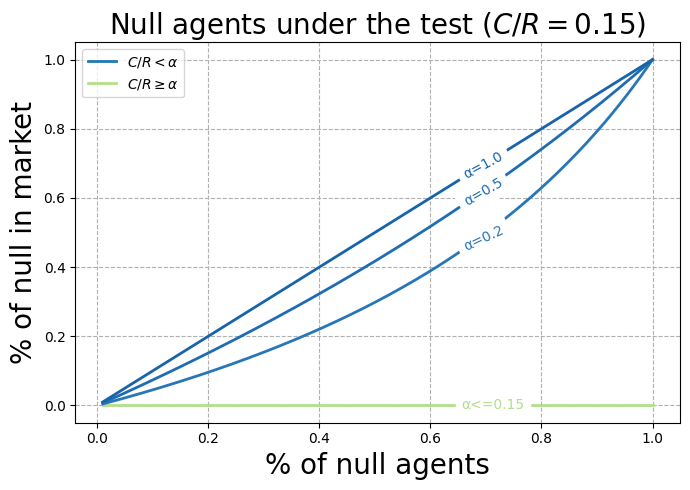

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# K ranges between 0 and 1
K = np.linspace(0.01, 1, 300)

# Different alpha values
powers = power_list
rotations= [25, 25, 30, 28, 28, 35]
# Color map for shades of blue
colors = plt.cm.Blues(np.linspace(0.5, 0.8, len(alpha_values)))
incentive_flag = True
# Plot
fig, ax = plt.subplots(figsize=(7,5))

for i, alpha in enumerate(alpha_values):
    if alpha < c_by_r:
        if incentive_flag:
            ax.plot(K, 0*K, color='#b2df8a', linewidth=2, label=r'$C/R \geq \alpha$')
            incentive_flag = False
        else: continue
    elif alpha == c_by_r:
        # y_incentivized line
        idx = int(len(K) * 0.65)  # choose a point at 70% along x-axis
        ax.text(K[idx], -0.01, f'α<={alpha}', color='#b2df8a',backgroundcolor='white', fontsize=10)
        count = i
    else:
        y = (alpha_values[i] * K) / ((1-K)*powers[i] + alpha_values[i]*K)
        line, = ax.plot(K, y, color=colors[i], linewidth=2)
        # Annotate alpha on the line
        idx = int(len(K) * 0.65)  # choose a point at 70% along x-axis
        ax.text(K[idx], y[idx]+0.001, f'α={alpha}', color=colors[i],  rotation=rotations[i-count],backgroundcolor='white', fontsize=10)

# Labels and title
ax.set_xlabel(r'% of null agents', fontsize=20)
ax.set_ylabel(r'% of null in market', fontsize=20)
ax.set_title(r'Null agents under the test $(C/R=0.15)$', fontsize=20)

# Grid and legend
ax.grid(True, linestyle='--')

# Create a custom legend for the blue lines
from matplotlib.lines import Line2D
blue_line = Line2D([0], [0], color='#1f78b4', linewidth=2, label=r'$C/R < \alpha$')
ax.legend(handles=[blue_line, ax.lines[0]])
plt.tight_layout()
plt.savefig("null.pdf", format="pdf", bbox_inches='tight')
plt.show()

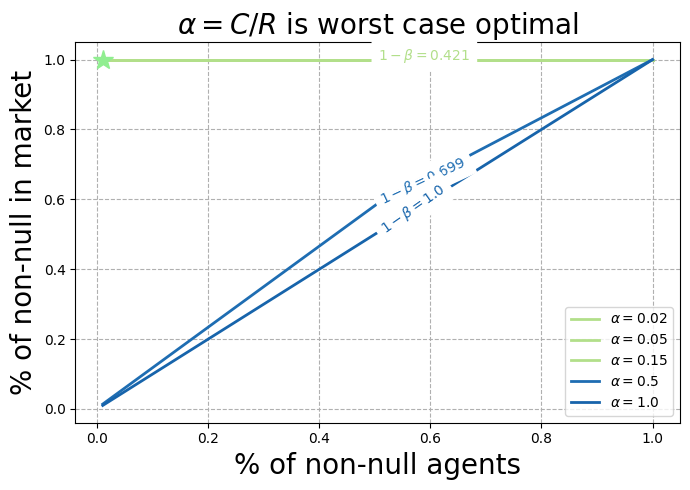

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# K ranges between 0 and 1
K = np.linspace(0.01, 1, 3)

# Different alpha values
rotations= [35, 35, 35, 35,35, 35, 30, 28, 28, 35]
# Color map for shades of blue
colors = plt.cm.Blues(np.linspace(0.5, 0.8, len(alpha_values)))
# Plot
fig, ax = plt.subplots(figsize=(7,5))

for i, alpha in enumerate(alpha_values):
    if alpha in [0.1, 0.2]:
        continue
    #print(alpha, powers[i])
    approved_non_null = np.array([])
    participants = np.array([])
    if powers[i] >= c_by_r:
        approved_non_null = powers[i]*K
        participants = powers[i]*K
    if alpha > c_by_r:
        participants=powers[i]*K + alpha*(1-K) # null agents participates because now it makes sense
    #print("participants:", participants)
    #print("approved_non_null:", approved_non_null)
    if np.size(participants)>0:
        y = approved_non_null/participants
        #print("y:",y)
        if alpha <= c_by_r:
            color='#b2df8a'
        else:
            color = colors[i]
        if alpha == 1.0: 
            rotation = 35
        elif alpha == 0.5:
            rotation = 25
        else: 
            rotation = 0 
        line, = ax.plot(K, y, color=color, linewidth=2, label=r'$\alpha=$' + f'{alpha}')
        idx = int(len(K) * 0.5)  # choose a point at 70% along x-axis
        ax.text(K[idx], y[idx], r'$1-\beta=$'+f'{powers[i]}', color=color, rotation = rotation, backgroundcolor='white', fontsize=10)

ax.plot(0.01, 1., marker='*', color='lightgreen', markersize=15)
# Labels and title
ax.set_xlabel(r'% of non-null agents', fontsize=20)
ax.set_ylabel(r'% of non-null in market', fontsize=20)
ax.set_title(r'$\alpha=C/R$ is worst case optimal', fontsize=20)

# Grid and legend
ax.grid(True, linestyle='--')

ax.legend()

plt.tight_layout()
plt.savefig("non_null.pdf", format="pdf", bbox_inches='tight')
plt.show()